In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Plotting
import matplotlib.pyplot as plt
import cv2 as cv

# Neural networks:
from keras.layers import Conv2D, Input, LeakyReLU, Dense, Activation, Flatten, Dropout, MaxPool2D
from keras import models
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import pickle
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Load and visualize the Dataset
#### MNIST Dataset:
* 60000 labeled images of handwritten numbers.
* Image size is 28 * 28.
* The images have only one color chanel(grayscale).
* Labeled from 0 to 9.

In [2]:
np.random.seed(1)
# Load Dataset
df_train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv") 
# Random permutation(the seed is used to resample the same permutation evey time)
df_train = df_train.iloc[np.random.permutation(len(df_train))]

In [3]:
df_train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
29633,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
345,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36369,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16624,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14389,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_train.shape

(42000, 785)

**The training set has 42000 images, with 784 pixels each(the other col is the label)**

## Separate training and test sets
In this case i'll be using 90% of the set for training and the other 10% for testing

In [5]:
sample_size = df_train.shape[0] # Training size
validation_size = int(df_train.shape[0] * 0.1) # Testing size

# train_x y train_y
# Take all the columns except for the 0th one
train_x = np.asarray(df_train.iloc[:sample_size - validation_size:, 1:]).reshape([sample_size - validation_size, 28, 28, 1])
train_y = np.asarray(df_train.iloc[:sample_size - validation_size:, 0]).reshape([sample_size - validation_size, 1])# 0th column

# val_x y val_y
val_x = np.asarray(df_train.iloc[sample_size - validation_size:,1:]).reshape([validation_size,28,28,1])
val_y = np.asarray(df_train.iloc[sample_size - validation_size:, 0]).reshape([validation_size, 1])

In [6]:
# Training set size:
train_x.shape, train_y.shape

((37800, 28, 28, 1), (37800, 1))

### **Load test.csv**

In [7]:
df_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
#Reshape it as a numpy array:
test_x = np.asarray(df_test.iloc[:, :]).reshape([-1, 28, 28, 1])

### **Normlalize the data:**
Each pixel values lies between [0, 255], This range is too high and can be difficult  for the model to learn, what we do is scale the range of pixels to [0, 1]

In [8]:
train_x = train_x/255
val_x = val_x/255
test_x = test_x/255

## Visualize digits dataset frequency
An important thing to do is is check the frequency of classes in the dataset, is always better to work with a balanced dataset.

**Frequency plot for the training set:**

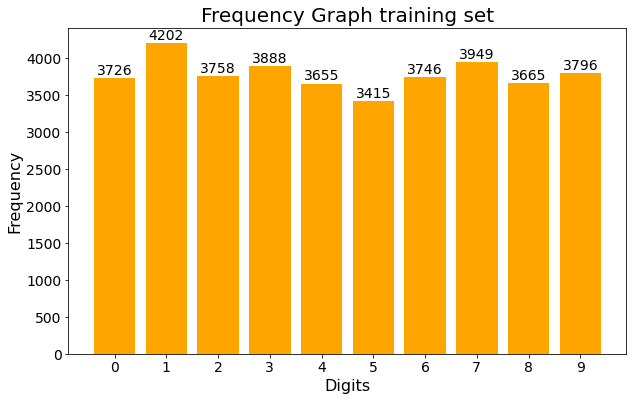

In [9]:
# First we check the frequency of digits in trainin and validation set
counts = df_train.iloc[:sample_size - validation_size, :].groupby('label')['label'].count()

f = plt.figure(figsize = (10, 6))
f.add_subplot(111)

plt.bar(counts.index, counts.values, width = 0.8, color = "orange")
for i in counts.index:
    plt.text(i, counts.values[i] + 50, str(counts.values[i]), horizontalalignment = 'center', fontsize = 14)

plt.tick_params(labelsize = 14)
plt.xticks(counts.index)
plt.xlabel("Digits", fontsize = 16)
plt.ylabel("Frequency", fontsize = 16)
plt.title("Frequency Graph training set", fontsize = 20)
plt.savefig('digit_frequency_train.png')
plt.show()

**Frequency plot for the training set:**

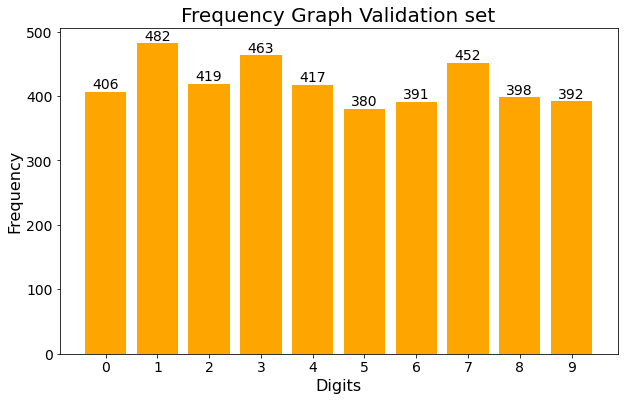

In [10]:
counts = df_train.iloc[sample_size - validation_size:, :].groupby('label')['label'].count()

f = plt.figure(figsize = (10, 6))
f.add_subplot(111)

plt.bar(counts.index, counts.values, width = 0.8, color = "orange")
for i in counts.index:
    plt.text(i, counts.values[i] + 5, str(counts.values[i]), horizontalalignment = 'center', fontsize = 14)

plt.tick_params(labelsize = 14)
plt.xticks(counts.index)
plt.xlabel("Digits", fontsize = 16)
plt.ylabel("Frequency", fontsize = 16)
plt.title("Frequency Graph Validation set", fontsize = 20)
plt.savefig('digit_frequency_Val.png')
plt.show()

It seems that there's a good balance of classes on the Train and Test sets

### **Visualizing the digits**

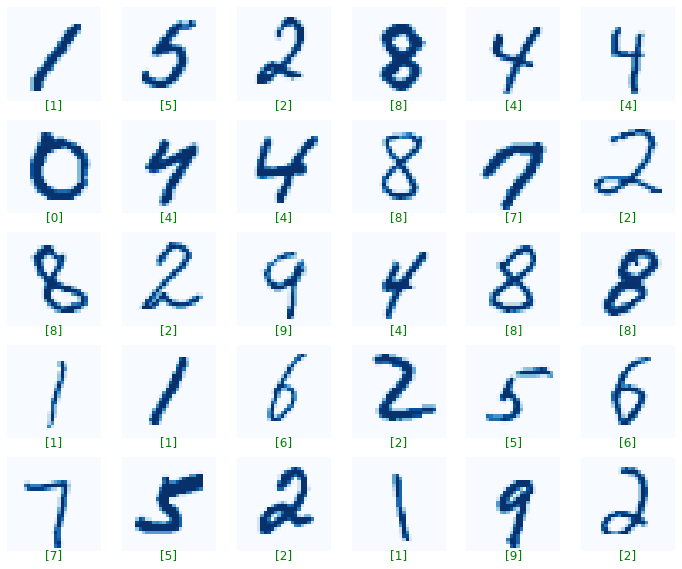

In [11]:
rows = 5
cols = 6

f = plt.figure(figsize = (2*cols, 2*rows))

for i in range(rows*cols):
    f.add_subplot(rows, cols, i + 1)#Adding a suubplot on each iteration
    plt.imshow(train_x[i].reshape([28, 28]), cmap = "Blues")
    plt.axis("off")
    plt.title(str(train_y[i]), y = -0.15, color = "green")
plt.savefig("digits.png")

# Building the model
## Convolutional neural network
**Description of the model:**
* 2 convolutional blocks(with leaky relu) with 2 MaxPool layers and a dropout layer.
* The output layer has 10 nodes with sigmoid activation

In [12]:
#Define the model sequential
model = models.Sequential()

In [13]:
# Block 1
model.add(Conv2D(32,3, padding  ="same",input_shape=(28, 28, 1)))
model.add(LeakyReLU())
model.add(Conv2D(32,3, padding  ="same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64,3, padding  ="same"))
model.add(LeakyReLU())
model.add(Conv2D(64,3, padding  ="same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation="sigmoid"))

## Compile the model:
I'll be using "Sparse categorical crossentropy" as a loss, accuracy as the performance metric and Adam as optimization algorithm. 

In [14]:
initial_lr = 0.001
loss = "sparse_categorical_crossentropy"
model.compile(Adam(lr = initial_lr), loss = loss, metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1

### **Training**

In [15]:
epochs = 20 # epochs
batch_size = 256 # batch size
history_1 = model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, validation_data = (val_x, val_y))

Epoch 1/20
148/148 [==============================] - 9s 14ms/step - loss: 0.7727 - accuracy: 0.7418 - val_loss: 0.0909 - val_accuracy: 0.9750
Epoch 2/20
148/148 [==============================] - 2s 10ms/step - loss: 0.0758 - accuracy: 0.9767 - val_loss: 0.0620 - val_accuracy: 0.9821
Epoch 3/20
148/148 [==============================] - 2s 11ms/step - loss: 0.0520 - accuracy: 0.9847 - val_loss: 0.0483 - val_accuracy: 0.9843
Epoch 4/20
148/148 [==============================] - 2s 10ms/step - loss: 0.0419 - accuracy: 0.9868 - val_loss: 0.0532 - val_accuracy: 0.9845
Epoch 5/20
148/148 [==============================] - 2s 10ms/step - loss: 0.0302 - accuracy: 0.9900 - val_loss: 0.0402 - val_accuracy: 0.9874
Epoch 6/20
148/148 [==============================] - 2s 10ms/step - loss: 0.0223 - accuracy: 0.9929 - val_loss: 0.0405 - val_accuracy: 0.9879
Epoch 7/20
148/148 [==============================] - 2s 11ms/step - loss: 0.0179 - accuracy: 0.9943 - val_loss: 0.0387 - val_accuracy: 0.9876

## Training performance

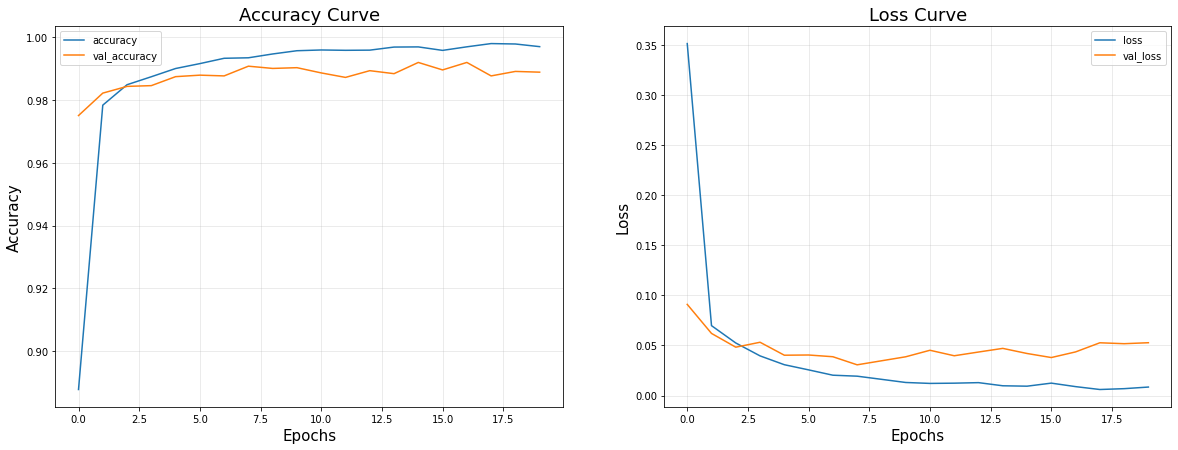

In [16]:
#Deffining figure:
f = plt.figure(figsize = (20, 7))

#Adding accuracy subplot
f.add_subplot(121)

#Accuracy curve for training set
plt.plot(history_1.epoch, history_1.history['accuracy'], label = "accuracy")
#Accuracy curve for test set
plt.plot(history_1.epoch, history_1.history['val_accuracy'], label = "val_accuracy")

plt.title("Accuracy Curve", fontsize = 18)
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.grid(alpha = 0.3)
plt.legend()

#Adding loss subplot
f.add_subplot(122)

#Loss curve for the training set
plt.plot(history_1.epoch,history_1.history['loss'],label="loss")
#Loss curve for the test set
plt.plot(history_1.epoch,history_1.history['val_loss'],label="val_loss")

plt.title("Loss Curve", fontsize = 18)
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.grid(alpha = 0.3)
plt.legend()

plt.show()

As we see, the accuracy and error of the test set are worse than the ones from the train set, it means the algorithm is overfiting.

Let's analize the performance of the algorithm on the test set more deeper.

## Confusion Matrix:
Each row of the matrix represents the instances in a predicted class, while each column represents the instances in an actual class (or vice versa). The name stems from the fact that it makes it easy to see if the system is confusing two classes.

In [17]:
val_p = np.argmax(model.predict(val_x), axis = 1)

#Fill the confusion matrix and sumarize the error:
error = 0
confusion_matrix = np.zeros([10, 10])
for i in range(val_x.shape[0]):
    confusion_matrix[val_y[i], val_p[i]] += 1
    if val_y[i] != val_p[i]:
        error += 1
        
print("Confusion Matrix: \n\n", confusion_matrix)
print("\nErrors in validation set: ", error)
print("\nError Persentage: ", (error * 100) / val_p.shape[0])
print("\nAccuracy: ", 100 - (error * 100) / val_p.shape[0])
print("\nValidation set Shape: ", val_p.shape[0])

Confusion Matrix: 

 [[402.   0.   3.   0.   0.   0.   1.   0.   0.   0.]
 [  0. 473.   2.   0.   1.   0.   1.   5.   0.   0.]
 [  0.   0. 419.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1. 461.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   1.   0. 413.   0.   1.   1.   1.   0.]
 [  0.   0.   1.  38.   0. 340.   0.   0.   0.   1.]
 [  2.   0.   2.   0.   1.   2. 384.   0.   0.   0.]
 [  0.   0.   7.   0.   2.   0.   0. 443.   0.   0.]
 [  0.   0.   1.   0.   0.   2.   0.   0. 395.   0.]
 [  1.   0.   0.   0.   4.   2.   0.   5.   1. 379.]]

Errors in validation set:  91

Error Persentage:  2.1666666666666665

Accuracy:  97.83333333333333

Validation set Shape:  4200


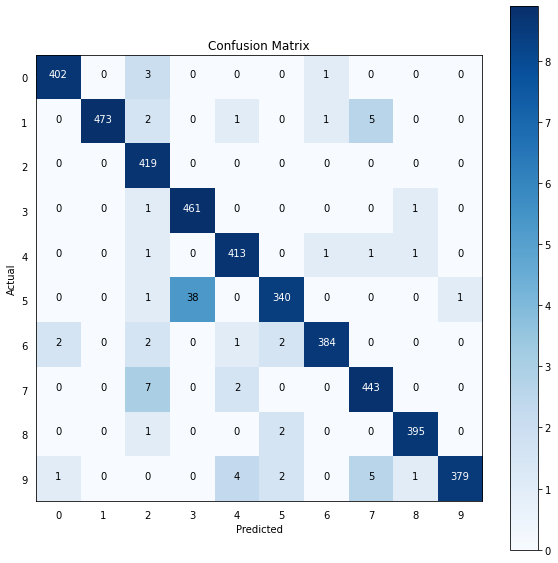

In [18]:
# Ploting confusion matrix:
f = plt.figure(figsize = (10, 10))
f.add_subplot(111)

plt.imshow(np.log2(confusion_matrix + 1), cmap = "Blues")
plt.colorbar()
plt.tick_params(size = 5, color = "white")
plt.xticks(np.arange(0, 10), np.arange(0, 10))
plt.yticks(np.arange(0, 10), np.arange(0, 10))

threshold = confusion_matrix.max()/2

for i in range(10):
    for j in range(10):
        plt.text(j, i, int(confusion_matrix[i, j]), horizontalalignment = "center", color = "white" if confusion_matrix[i, j] > threshold else "black")
        

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("Confusion_matrix1.png")
plt.show()

# Improve results by image augmentation
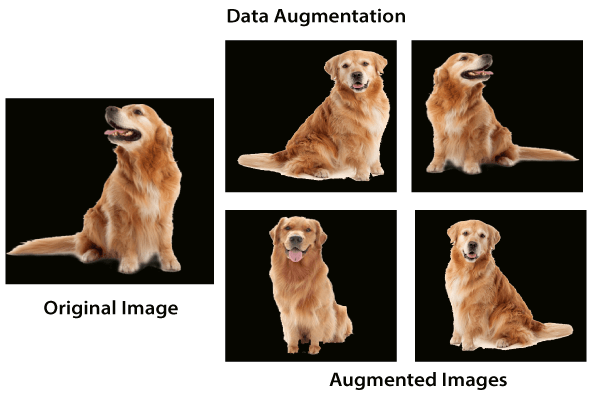

For improving the results we'll be using image augmentation, which is a technique widely used in machine learning, where we pick examples of data and we slightly change them by roting them or flipping them, etc.

In [19]:
# Function of keras for image augmentation
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 10, #Rotate images in range
    zoom_range = 0.1, #Zoom image
    width_shift_range = 0.1, #Shift images horizontaly
    height_shift_range = 0.1, #Shift images vertically
    horizontal_flip = False,
    vertical_flip = False)
datagen.fit(train_x)

In [20]:
# Keras function used tu reduce the learning rate when a metric has stopped improving
lrr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)

## Training
We'll use now the model.fit_generator() funcion, which is the function used for training on a generated batch.

In [21]:
epochs = 30
history_2 = model.fit_generator(datagen.flow(train_x, train_y, batch_size = batch_size), steps_per_epoch = int(train_x.shape[0]/batch_size) + 1, epochs = epochs, validation_data = (val_x, val_y), callbacks = [lrr])


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
148/148 [==============================] - 12s 81ms/step - loss: 0.1259 - accuracy: 0.9639 - val_loss: 0.0395 - val_accuracy: 0.9879
Epoch 2/30
148/148 [==============================] - 10s 69ms/step - loss: 0.0648 - accuracy: 0.9799 - val_loss: 0.0297 - val_accuracy: 0.9900
Epoch 3/30
148/148 [==============================] - 10s 69ms/step - loss: 0.0530 - accuracy: 0.9840 - val_loss: 0.0318 - val_accuracy: 0.9895
Epoch 4/30
148/148 [==============================] - 11s 73ms/step - loss: 0.0464 - accuracy: 0.9850 - val_loss: 0.0292 - val_accuracy: 0.9929
Epoch 5/30
148/148 [==============================] - 11s 72ms/step - loss: 0.0446 - accuracy: 0.9858 - val_loss: 0.0364 - val_accuracy: 0.9910
Epoch 6/30
148/148 [==============================] - 12s 81ms/step - loss: 0.0369 - accuracy: 0.9886 - val_loss: 0.0345 - val_accuracy: 0.9905

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/30
148/148 [==============================] - 1

### Training performance
After the training with the new generated data, let's see the results.

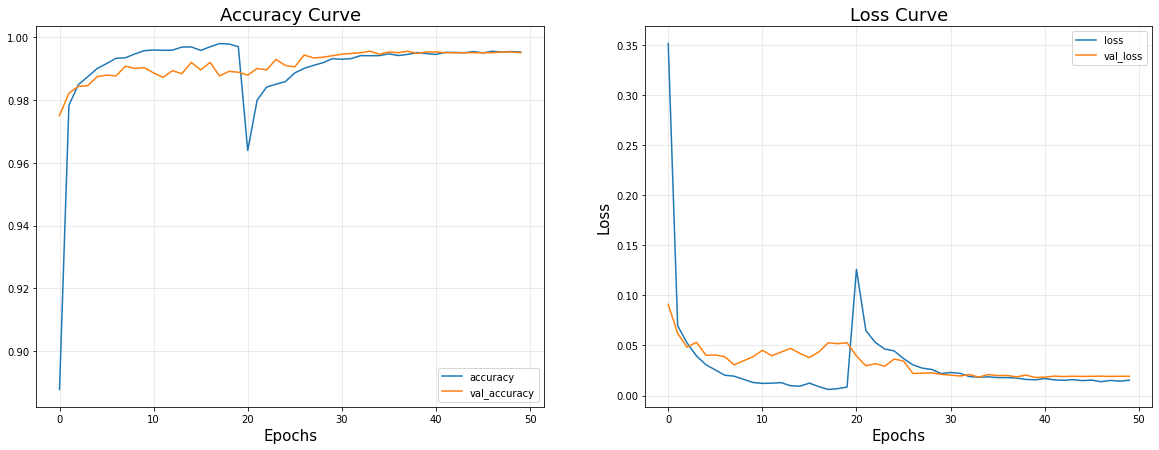

In [22]:
# Deffining figure
f = plt.figure(figsize = (20, 7))
f.add_subplot(121)

# Adding accuracy subplot
#Train
plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['accuracy']+history_2.history['accuracy'],label = "accuracy")
#Test
plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['val_accuracy']+history_2.history['val_accuracy'],label = "val_accuracy")

plt.title("Accuracy Curve", fontsize = 18)
plt.xlabel("Epochs", fontsize = 15)
plt.grid(alpha = 0.3)
plt.legend()

# Adding loss subplot
f.add_subplot(122)
#Train
plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['loss']+history_2.history['loss'],label="loss") 
#Test
plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['val_loss']+history_2.history['val_loss'],label="val_loss")

plt.title("Loss Curve", fontsize = 18)
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.grid(alpha = 0.3)
plt.legend()

plt.show()

## **Confusion Matrix**

In [23]:
val_p = np.argmax(model.predict(val_x), axis = 1)

error = 0
confusion_matrix = np.zeros([10, 10])
for i in range(val_x.shape[0]):
    confusion_matrix[val_y[i], val_p[i]] += 1
    if val_y[i] != val_p[i]:
        error += 1
        
print("Confusion Matrix: \n\n", confusion_matrix)
print("\nErrors in validation set: ", error)
print("\nError Persentage: ", (error * 100) / val_p.shape[0])
print("\nAccuracy: ", 100 - (error * 100) / val_p.shape[0])
print("\nValidation set Shape: ", val_p.shape[0])

Confusion Matrix: 

 [[406.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 478.   1.   0.   0.   0.   1.   2.   0.   0.]
 [  0.   0. 418.   0.   0.   0.   0.   1.   0.   0.]
 [  0.   0.   1. 461.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0. 415.   0.   1.   0.   1.   0.]
 [  0.   0.   0.   0.   0. 378.   0.   0.   1.   1.]
 [  0.   0.   0.   0.   1.   0. 389.   0.   1.   0.]
 [  0.   1.   1.   0.   0.   0.   0. 449.   0.   1.]
 [  0.   0.   1.   0.   0.   0.   0.   0. 397.   0.]
 [  0.   0.   0.   0.   2.   1.   0.   0.   1. 388.]]

Errors in validation set:  21

Error Persentage:  0.5

Accuracy:  99.5

Validation set Shape:  4200


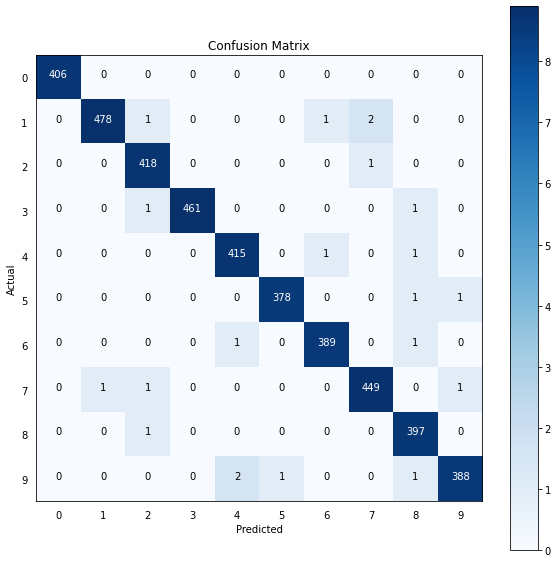

In [24]:
f = plt.figure(figsize = (10, 10))
f.add_subplot(111)

plt.imshow(np.log2(confusion_matrix + 1), cmap = "Blues")
plt.colorbar()
plt.tick_params(size = 5, color = "white")
plt.xticks(np.arange(0, 10), np.arange(0, 10))
plt.yticks(np.arange(0, 10), np.arange(0, 10))

threshold = confusion_matrix.max()/2

for i in range(10):
    for j in range(10):
        plt.text(j, i, int(confusion_matrix[i, j]), horizontalalignment = "center", color = "white" if confusion_matrix[i, j] > threshold else "black")
        

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("Confusion_matrix2.png")
plt.show()

# Visualizing results
## Errors in the validation set:

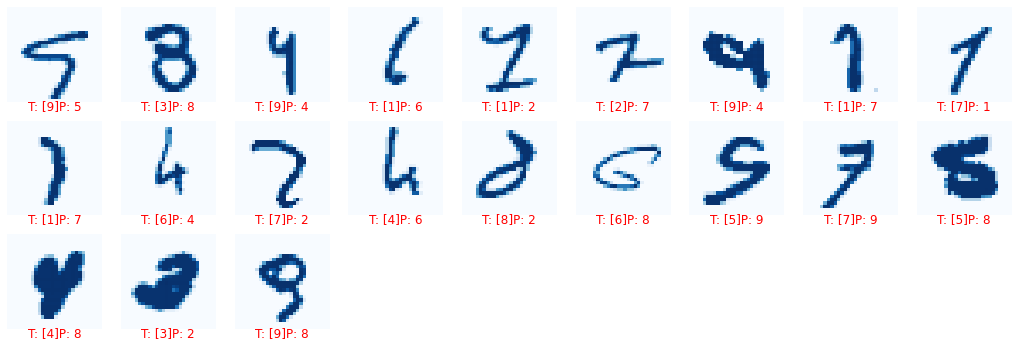

In [25]:
rows = 4
cols = 9

f = plt.figure(figsize = (2*cols, 2*rows))
subplot = 1
for i in range(val_x.shape[0]):
    if val_y[i] != val_p[i]:
        f.add_subplot(rows, cols, subplot)
        subplot += 1
        plt.imshow(val_x[i].reshape([28, 28]), cmap = "Blues")
        plt.axis("off")
        plt.title("T: " + str(val_y[i]) + "P: " + str(val_p[i]), y = -0.15, color = "Red")
        
plt.savefig("error_plots.png")
plt.show()

# Predictions on the test set:

In [26]:
test_y = np.argmax(model.predict(test_x), axis = 1)

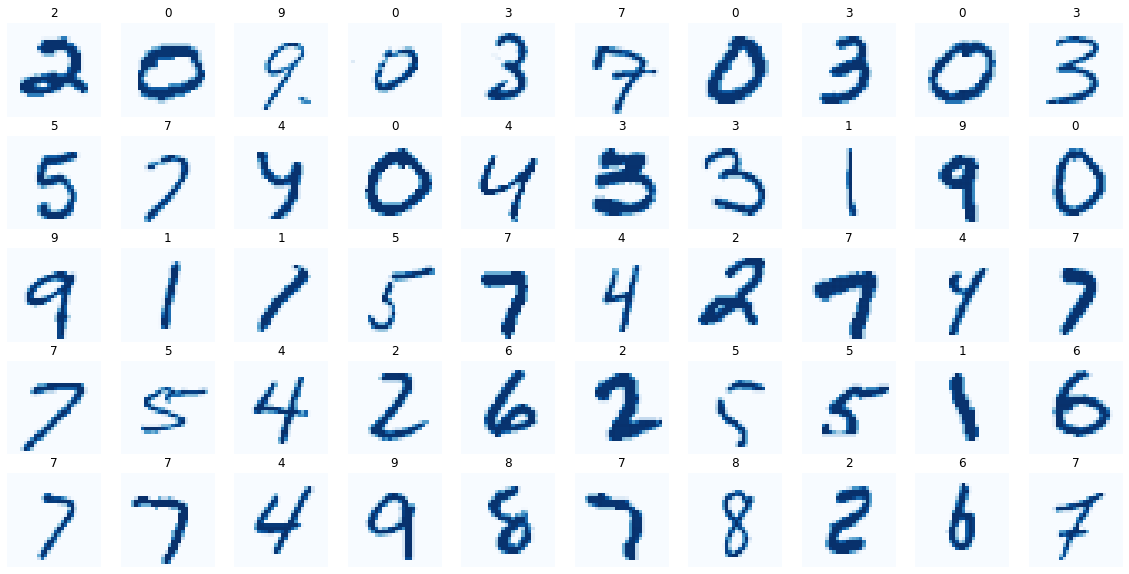

In [27]:
rows = 5
cols = 10

f = plt.figure(figsize = (2*cols, 2*rows))

for i in range(rows*cols):
    f.add_subplot(rows, cols, i+1)
    plt.imshow(test_x[i]. reshape([28, 28]), cmap = "Blues")
    plt.axis("off")
    plt.title(str(test_y[i]))

## Creating submission

In [28]:
df_submission = pd.DataFrame([df_test.index + 1, test_y], ["ImageId", "Label"]).transpose()
df_submission.to_csv("MySubmission.csv", index = False)

## 